In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
def RBF_kernel(X1, X2, l = 1.0, sigma_f = 1.0):
    '''
    Isotropic squared exponential kernal (radial basis function kernel). Computes
    a covariance matrix from points in X1 and X2.
    Args:
        X1: Array of m points 
        X2: array of n points
    
    Returns:
        Covariance matrix(m X n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1,1) + np.sum(X2**2, 1) -  2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [46]:
def RBF_noise_kernel(X1, X2, l = 1.0, sigma_f = 1.0, sigma_y = 1.0):
    '''
    Isotropic squared exponential kernal (radial basis function kernel). Computes
    a covariance matrix from points in X1 and X2.
    Args:
        X1: Array of m points 
        X2: array of n points
    
    Returns:
        Covariance matrix(m X n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1,1) + np.sum(X2**2, 1) -  2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist) + sigma_y**2 * np.eye(len(X_train))

In [4]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    '''
    Plots a Gaussian Process.
    Args:
        mu: array of means
        cov: covariance matrix from a kernel
        X: array of points
        samples : samples from the multivariate GP
    '''
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

In [5]:
#Draw a finite set of points from the domain
X = np.arange(-5, 5, 0.2)
#Reshape into a column array
X = X.reshape(-1,1)

#Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = RBF_kernel(X,X)

#Draw three samples from the prior 
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

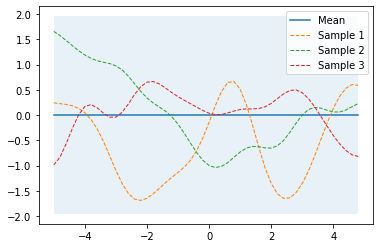

In [6]:
#Plot gp mean, confidence interval, and samples
plot_gp(mu, cov, X, samples=samples)

In [7]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l = 1.0, sigma_f = 1.0, sigma_y = 1e-8, kernel = RBF_kernel):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
        kernel: kernel function for the GP
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    #Create kernel with noise added along the matrix diagonal
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    #Get covariance of new inputs from X_train
    K_s = kernel(X_train, X_s, l , sigma_f)
    #Get Covariance of new inputs, with noise
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    #get inverse of X_train covariance matrix
    K_inv = inv(K)
    
    #Calculate mean of the posterior predictive distribution 
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    
    #Calculate covariance matrix of the posterior predictive distribution 
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

## Prediction from noise free training data

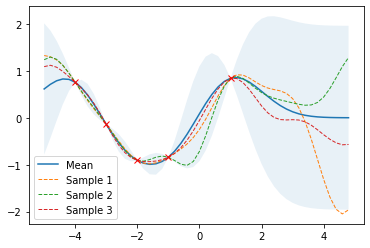

In [8]:
#Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
Y_train = np.sin(X_train)

#Compute mean and covariance of thje posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples = samples)

## Prediction from noisy training data

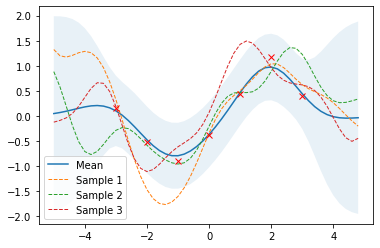

In [9]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

## Effect of kernel and noise parameter

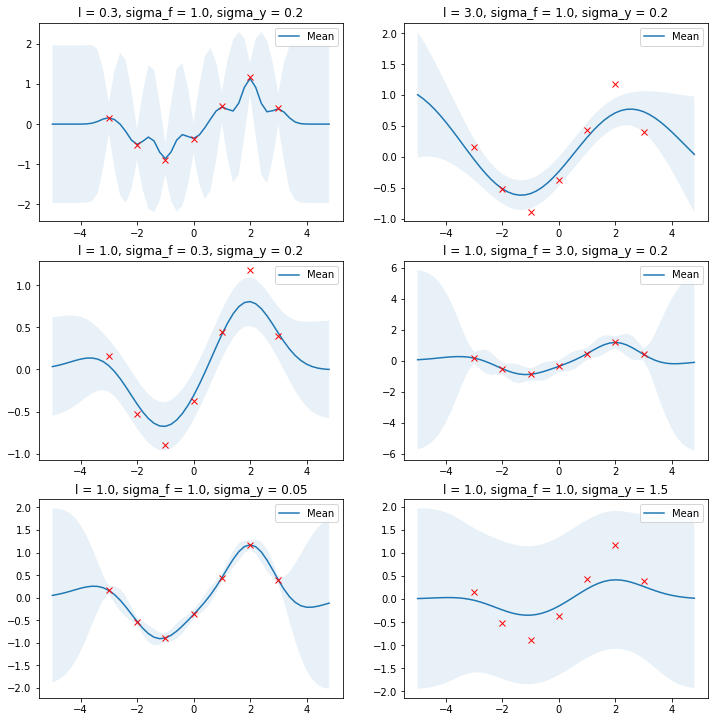

In [10]:
params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

#Calculate mean and variance for each param and plot
for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, sigma_f = sigma_f, sigma_y=  sigma_y)
    
    plt.subplot(3, 2, i+1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
    

#### MInimize the negative log likelihood with a known noise level for y, sigma_y

In [15]:
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    '''
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (7), if 
               False use a numerically more stable implementation. 
        
    Returns:
        Minimization objective.
    '''
    def nll_naive(theta):
        # Naive implementation of the equation for log marginal likeliehood. Works well for simple examples 
        # but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = RBF_kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of  equation for log marginal likeliehood as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        K = RBF_kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    
    if naive:
        return nll_naive
    else:
        return nll_stable

In [16]:
# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# Can run the minimization several times with different
# initializations to avoid local minima.
res = minimize(nll_fn(X_train, Y_train, noise), [1,1], 
              bounds = ((1e-5, None), (1e-5, None)),
              method = 'L-BFGS-B')

In [20]:
l_opt, sigma_f_opt = res.x
l_opt, sigma_f_opt

(1.237621230157874, 0.5627429685304712)

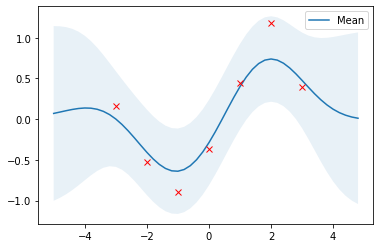

In [53]:
# Compute the posterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l = l_opt, sigma_f = sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train= X_train, Y_train= Y_train)

#### MInimize the negative log likelihood for an unknown noise level for y, sigma_y

In [47]:
def nll_full_fn(X_train, Y_train, naive=True):
    '''
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and an unknown 
    noise level.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        naive: if True use a naive implementation of Eq. (7), if 
               False use a numerically more stable implementation. 
        
    Returns:
        Minimization objective.
    '''
    def nll_naive(theta):
        # Naive implementation of the equation for log marginal likeliehood. Works well for simple examples 
        # but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = RBF_noise_kernel(X_train, X_train, l=theta[0], sigma_f=theta[1], sigma_y=theta[2])
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of  equation for log marginal likeliehood as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        K = RBF_noise_kernel(X_train, X_train, l=theta[0], sigma_f=theta[1], sigma_y=theta[2])
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    
    if naive:
        return nll_naive
    else:
        return nll_stable

In [48]:
# Minimize the negative log-likelihood w.r.t. parameters l, sigma_f, and sigma_y.
# Can run the minimization several times with different
# initializations to avoid local minima.


res = minimize(nll_full_fn(X_train, Y_train), [1,1,1], 
              bounds = ((1e-5, None), (1e-5, None),(1e-5, None)),
              method = 'L-BFGS-B')

In [52]:
l_full_opt, sigma_f_full_opt, sigma_y_full_opt = res.x
l_full_opt, sigma_f_full_opt, sigma_y_full_opt 

(1.0720317171328955, 0.6493445585531669, 0.07902762213029077)

#### Maximizing the log likelihood across an unknown noise factor instead of the actual one results in a smaller value for l and sigma_y, which gives a tighter confidence interval near the training points at the cost of potential overfitting.

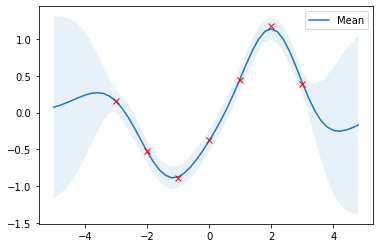

In [54]:
# Compute the posterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l = l_full_opt, sigma_f = sigma_f_full_opt, sigma_y=sigma_y_full_opt)
plot_gp(mu_s, cov_s, X, X_train= X_train, Y_train= Y_train)

## Higher dimensions

In [71]:
noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

#Convert points into an array of 2d vectors
X_2D = np.c_[gx.ravel(), gy.ravel()]


X_2D_train = np.random.uniform(-4, 4, (100,2))
#Create y as a noisy sine wave originating at 0,0
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis =1)) + \
             noise_2d * np.random.randn(len(X_2D_train))

In [75]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

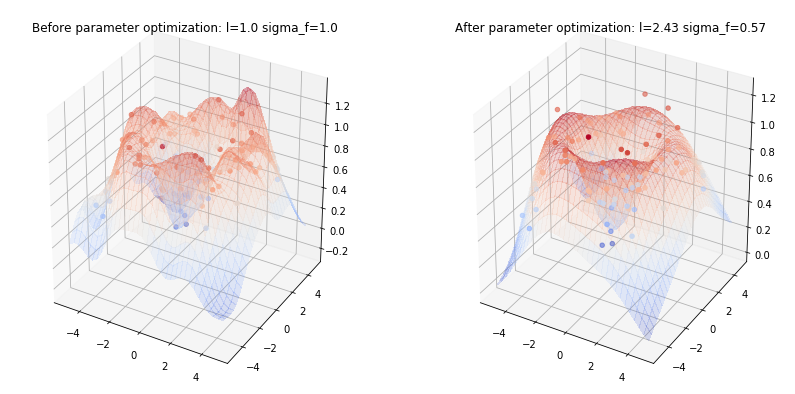

In [77]:
plt.figure(figsize=(14,7))
mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

#Minimize the negative log likelihood to find l and sigma_f
res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

In [69]:
np.linalg.norm(X_2D_train, axis =1)

array([4.52827032, 4.02741078, 3.31993777, 2.38520873, 3.34947266,
       3.4467681 , 0.41188987, 1.87935159, 3.23720091, 1.32783282,
       3.47478732, 2.76932751, 3.29744218, 3.71689462, 0.91039811,
       4.14476306, 2.96008263, 1.33101426, 3.74215252, 3.42756107,
       4.17811208, 3.79464016, 4.93573102, 3.32578825, 4.19601213,
       4.25138053, 0.71430165, 3.5781642 , 3.78347705, 3.97603584,
       5.09914989, 3.55070767, 3.41308234, 2.26135973, 3.93868234,
       2.63852209, 2.5412385 , 1.79584591, 2.24441695, 4.38109784,
       3.18530588, 3.83771322, 1.61868801, 3.56425975, 3.55656148,
       4.54877782, 2.92914698, 1.99666302, 1.11877298, 4.10347124,
       1.61138841, 3.9790334 , 3.36671593, 0.91827236, 1.58633269,
       3.89221908, 2.25610485, 4.61385077, 3.04206574, 4.5462901 ,
       4.92787692, 4.48923465, 1.86984948, 3.13103099, 3.97351755,
       2.57657638, 0.28600405, 3.20910799, 3.81532882, 4.2940457 ,
       2.03852907, 1.42032781, 3.53395232, 0.28287432, 3.70715

In [44]:
X_train = X
l= 1
sigma_f = 1
sigma_y = 1e-8

In [31]:
K = RBF_kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))

In [34]:
 np.eye(len(X_train))

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])